In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 21:09:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   28C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_labels(base_path, class_label):
    images = []
    labels = []
    for filename in os.listdir(base_path):
        filepath = os.path.join(base_path, filename)
        if filepath.endswith(".png") and not "_mask" in filepath:
            images.append(filepath)
            labels.append(class_label)
    return images, labels

# Load benign and malignant images and masks
benign_images, benign_labels = load_images_and_labels("./Dataset_BUSI_with_GT/benign/", 0)
malignant_images, malignant_labels  = load_images_and_labels("./Dataset_BUSI_with_GT/malignant/", 1)

# Combine benign and malignant images and masks
images = benign_images + malignant_images
labels = benign_labels + malignant_labels

# Split the dataset into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, labels, img_width, img_height, is_augment=True):
        self.images = images
        self.labels = labels
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        mask = Image.open(self.images[index][:-4] + "_mask.png").resize((self.img_width, self.img_height))
        mask = np.array(mask, dtype=np.float32)
        label = torch.from_numpy(np.array(self.labels))[index].type(torch.LongTensor)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                mask = cv2.warpAffine(mask, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                mask = cv2.flip(mask, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])
        
        y_transform = transforms.Compose([
            ToLabel(),
        ])

        img_new = tfms(img_new)
        mask = y_transform(mask)

        return img_new, label, mask

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, labels_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, labels_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))





Training samples #:  517
Test samples #:  130


In [6]:
from models.vmamba import VSSM

class MultiVmamba(nn.Module):
    def __init__(self, n_classes, is_pretrain):
        super(MultiVmamba, self).__init__()

        # Load a pretrained ResNet50 model
        vmamba = VSSM(
            patch_size=4,
            in_chans=3,
            num_classes=1000,
            depths=[ 2, 2, 4, 2 ],
            dims=96,
            # ===================
            ssm_d_state=1,
            ssm_ratio=2.0,
            ssm_rank_ratio=2.0,
            ssm_dt_rank="auto",
            ssm_act_layer="silu",
            ssm_conv=3,
            ssm_conv_bias=False,
            ssm_drop_rate=0.0,
            ssm_init="v0",
            forward_type="v2",
            # ===================
            mlp_ratio=4.0,
            mlp_act_layer="gelu",
            mlp_drop_rate=0.0,
            # ===================
            drop_path_rate=0.2,
            patch_norm=True,
            norm_layer="ln",
            downsample_version="v3",
            patchembed_version="v2",
            use_checkpoint=False,
        )
        if is_pretrain:
            state_dict = torch.load('./pretrained/vssmtiny_dp02_ckpt_epoch_258.pth')['model']
            vmamba.load_state_dict(state_dict)
        
       
        self.classifier = vmamba.classifier
        self.classifier[-1] = nn.Linear(in_features=768, out_features=2, bias=True)
        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = vmamba.patch_embed
        self.enc_features2 = vmamba.layers[0]
        self.enc_features3 = vmamba.layers[1]
        self.enc_features4 = vmamba.layers[2]
        self.enc_features5 = vmamba.layers[3]
        # Now, self.enc_features contains the encoder part of ResNet50
 
        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(768, 384)
        self.dec3 = self._make_dec_block(1536, 768)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(384, 192)
        self.dec2 = self._make_dec_block(768, 384)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(192, 96)
        self.dec1 = self._make_dec_block(384, 192)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(96, 96)
        self.dec0 = self._make_dec_block(192, 96)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(96, 96)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(96, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x) # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        
        
        cls = self.classifier(x5)

        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        x3 = x3.permute(0, 3, 1, 2)
        x4 = x4.permute(0, 3, 1, 2)
        x5 = x5.permute(0, 3, 1, 2)

        # Decoder with skip connections
        
        x = self.dec3(torch.cat([x5, x4], dim=1))  # Use skip connection from layer3
        x = self.upconv3(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2
        x = self.upconv2(x)

        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1
        x = self.upconv1(x)

        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1
        
        x = self.upconv0(x)

        x = self.upconv_final(x)
        

        
        return cls, self.final_conv(x)

model = MultiVmamba(2, True)
model = model.to(device)


# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


Epoch 1, Train loss: 0.6005738269199025
Epoch 1, Test loss: 0.5535761912663778
Epoch 2, Train loss: 0.35359875270814606
Epoch 2, Test loss: 0.32203387055132127
Epoch 3, Train loss: 0.2635881115089763
Epoch 3, Test loss: 0.22608135475052726
Epoch 4, Train loss: 0.2207521985877644
Epoch 4, Test loss: 0.19130351808336046
Epoch 5, Train loss: 0.19066868406353574
Epoch 5, Test loss: 0.21194409827391306
Epoch 6, Train loss: 0.17110289272033807
Epoch 6, Test loss: 0.17121679170264137
Epoch 7, Train loss: 0.15905890500906741
Epoch 7, Test loss: 0.18843226548698214
Epoch 8, Train loss: 0.1429105078180631
Epoch 8, Test loss: 0.1970858954721027
Epoch 9, Train loss: 0.13723708937565485
Epoch 9, Test loss: 0.15854371753003862
Epoch 10, Train loss: 0.12945958904244684
Epoch 10, Test loss: 0.19869447499513626
Epoch 11, Train loss: 0.1356077708981254
Epoch 11, Test loss: 0.16835870842138925
Epoch 12, Train loss: 0.10920856689864938
Epoch 12, Test loss: 0.17757177352905273
Epoch 13, Train loss: 0.10309

Epoch 100, Test loss: 0.15370292464892069


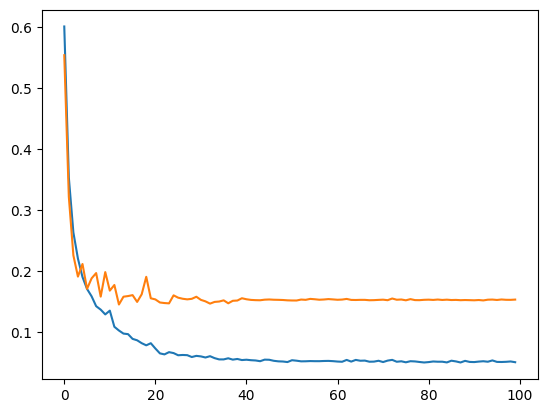

In [7]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, cls_label, seg_label) in enumerate(train_loader):
        image, cls_label, seg_label = image.to(device), cls_label.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output_cls, output_seg = model(image)

        # Calculate loss
        loss1 = loss_function(output_seg, seg_label)
        loss2 = loss_function(output_cls, cls_label)
        
        loss = loss1 + 0.1 * loss2

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, cls_label, seg_label in test_loader:
            image, cls_label, seg_label = image.to(device), cls_label.to(device), seg_label.to(device)
            y_predict_cls, y_predict_seg = model(image)
            loss1 = loss_function(y_predict_seg, seg_label)
            loss2 = loss_function(y_predict_cls, cls_label)
            loss = loss1 + 0.1 * loss2
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/Vmamba_Multi.pt")

./Dataset_BUSI_with_GT/malignant/malignant (30).png


/tmp/ipykernel_818564/1927148609.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)


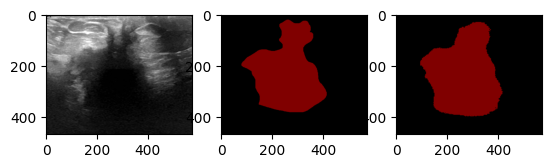

0.8328138039369692
0.9319880381222448
./Dataset_BUSI_with_GT/benign/benign (110).png


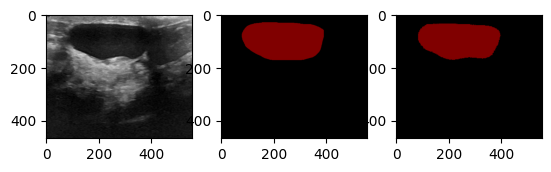

0.9156588495109896
0.9857366436650778
./Dataset_BUSI_with_GT/benign/benign (245).png


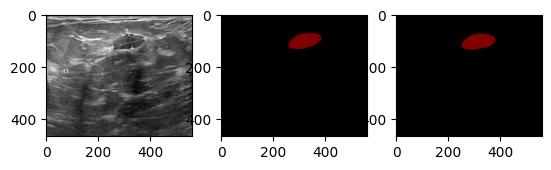

0.8356445004727387
0.995911359208458
./Dataset_BUSI_with_GT/benign/benign (22).png


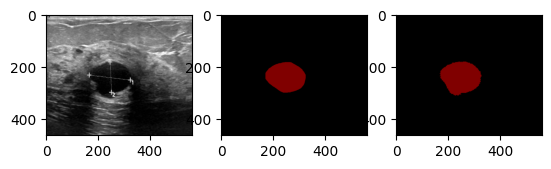

0.8935230941556302
0.9934480731415597
./Dataset_BUSI_with_GT/benign/benign (399).png


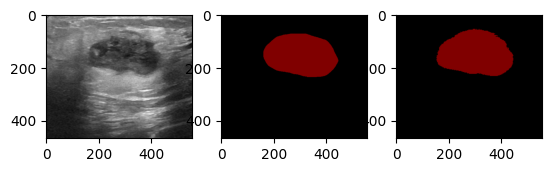

0.888984378949497
0.9804426236808123
./Dataset_BUSI_with_GT/malignant/malignant (133).png


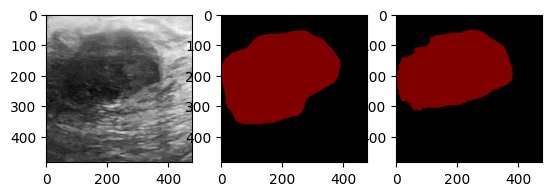

0.8231782065834279
0.9025113740902292
./Dataset_BUSI_with_GT/benign/benign (219).png


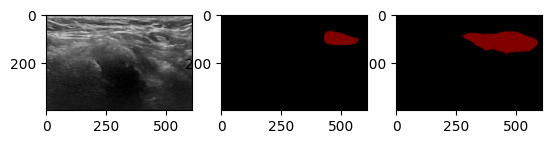

0.31533869711912793
0.943798920291615
./Dataset_BUSI_with_GT/benign/benign (427).png


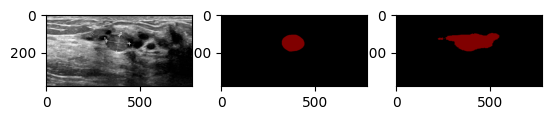

0.45918759962622985
0.9658422613054859
./Dataset_BUSI_with_GT/benign/benign (381).png


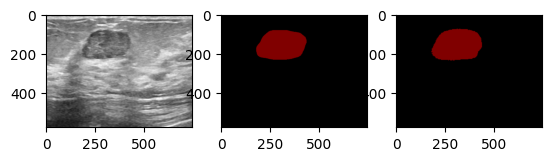

0.9216321243523317
0.9933277522395392
./Dataset_BUSI_with_GT/benign/benign (55).png


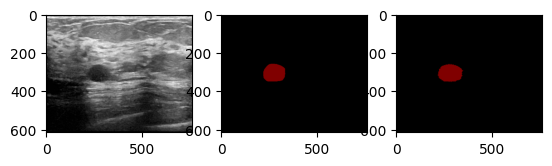

0.8845641708491242
0.9975491795079222
./Dataset_BUSI_with_GT/malignant/malignant (1).png


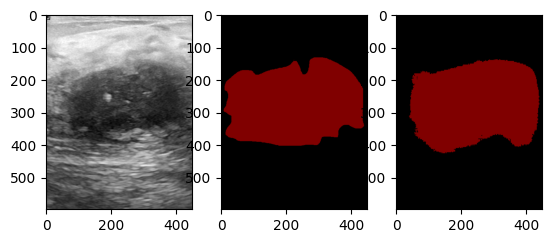

0.8238950898443366
0.905520437811159
./Dataset_BUSI_with_GT/benign/benign (362).png


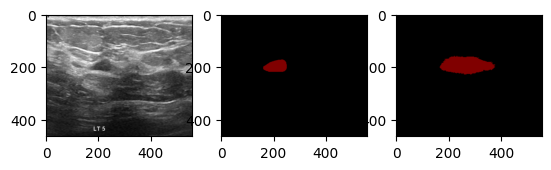

0.2878645343367827
0.9703588265697684
./Dataset_BUSI_with_GT/benign/benign (15).png


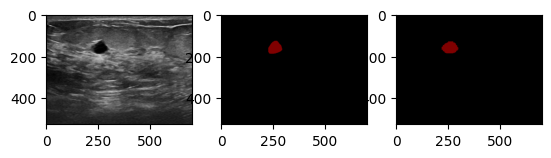

0.8070175438596491
0.9981056671441224
./Dataset_BUSI_with_GT/benign/benign (14).png


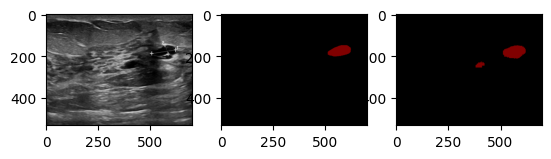

0.6778761061946903
0.9945443050392963
./Dataset_BUSI_with_GT/malignant/malignant (62).png


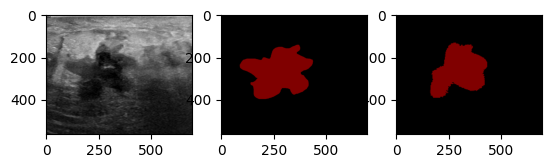

0.7072255777536868
0.9514504374425732
./Dataset_BUSI_with_GT/benign/benign (435).png


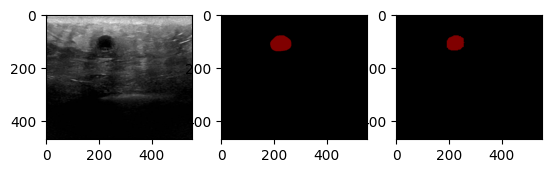

0.8008288008288008
0.996993698103176
./Dataset_BUSI_with_GT/benign/benign (191).png


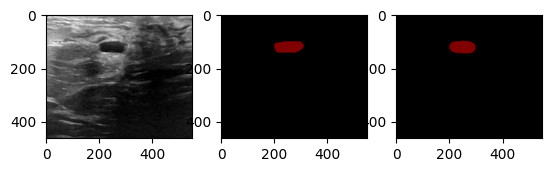

0.8265120509322419
0.9969547239694754
./Dataset_BUSI_with_GT/malignant/malignant (145).png


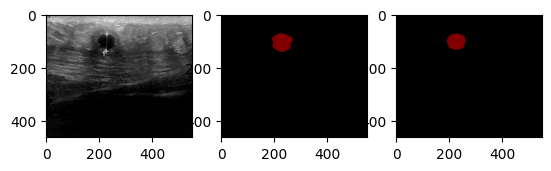

0.8084291187739464
0.9968092404396867
./Dataset_BUSI_with_GT/benign/benign (335).png


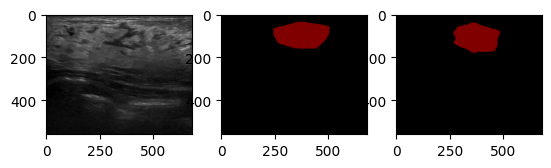

0.7122375293581519
0.9772200654343839
./Dataset_BUSI_with_GT/benign/benign (259).png


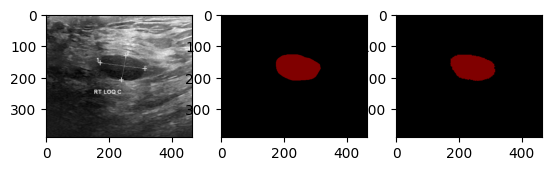

0.9335766423357664
0.9963050401109068
./Dataset_BUSI_with_GT/benign/benign (45).png


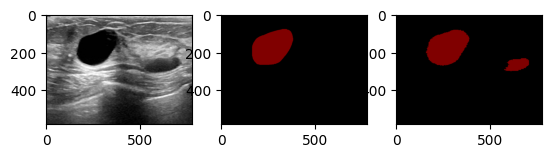

0.7887563884156729
0.9807822987327285
./Dataset_BUSI_with_GT/benign/benign (344).png


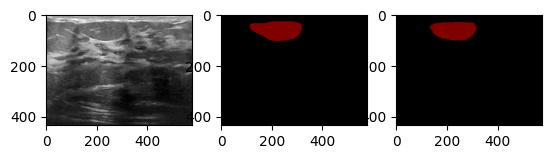

0.8612145748987854
0.9928388789544931
./Dataset_BUSI_with_GT/benign/benign (199).png


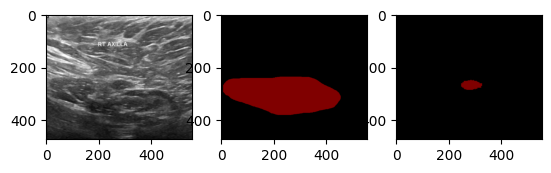

0.045912722802704364
0.821401588513003
./Dataset_BUSI_with_GT/benign/benign (240).png


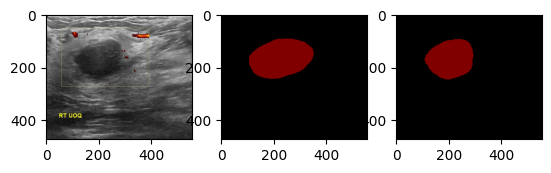

0.7480550568521843
0.9703935665886207
./Dataset_BUSI_with_GT/malignant/malignant (140).png


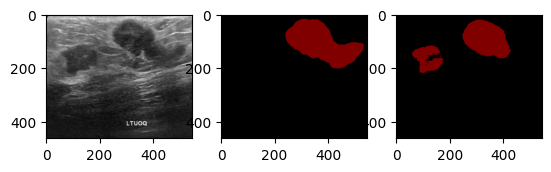

0.4967793001801408
0.9214099072025644
./Dataset_BUSI_with_GT/benign/benign (385).png


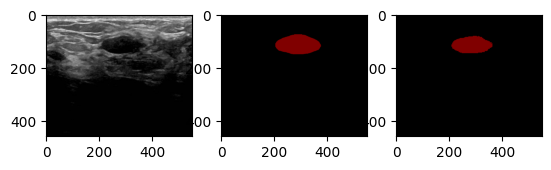

0.7847101077475629
0.9914266216067116
./Dataset_BUSI_with_GT/benign/benign (125).png


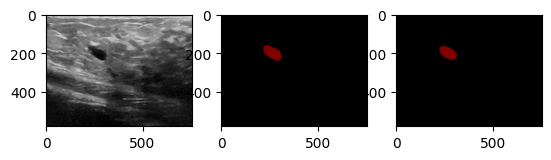

0.8487361769352291
0.9982295976148103
./Dataset_BUSI_with_GT/benign/benign (72).png


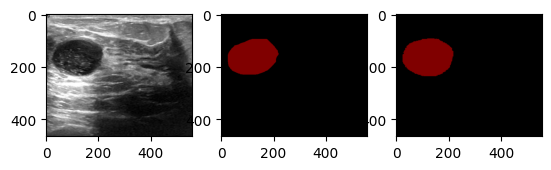

0.8932750474676557
0.9898774997382473
./Dataset_BUSI_with_GT/malignant/malignant (56).png


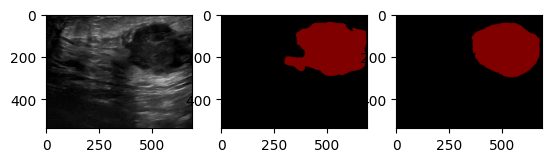

0.8352289898074123
0.9613584307560475
./Dataset_BUSI_with_GT/benign/benign (196).png


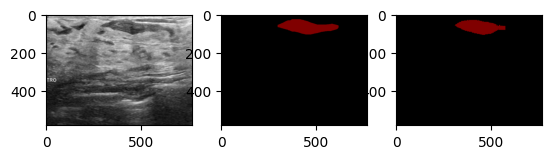

0.7937436419125127
0.9924871930263365
./Dataset_BUSI_with_GT/malignant/malignant (120).png


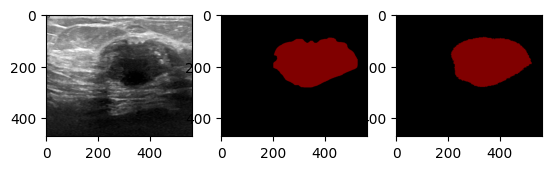

0.9043569307036475
0.9799063553558361
./Dataset_BUSI_with_GT/benign/benign (346).png


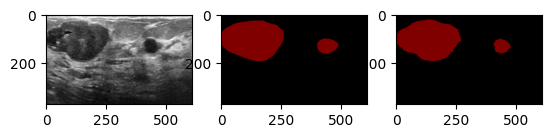

0.9079336734693878
0.9811971511782389
./Dataset_BUSI_with_GT/benign/benign (139).png


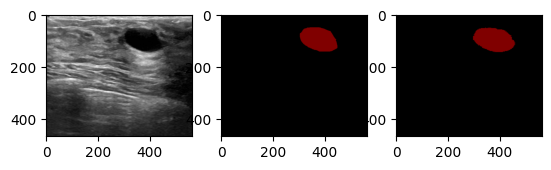

0.8855379801842517
0.9948005290274187
./Dataset_BUSI_with_GT/malignant/malignant (59).png


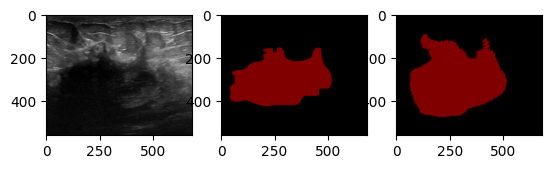

0.7006328338709019
0.8764753250516343
./Dataset_BUSI_with_GT/malignant/malignant (8).png


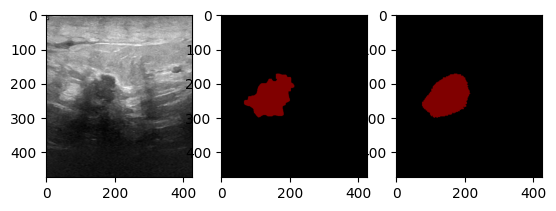

0.8238471776403351
0.98821835318759
./Dataset_BUSI_with_GT/benign/benign (319).png


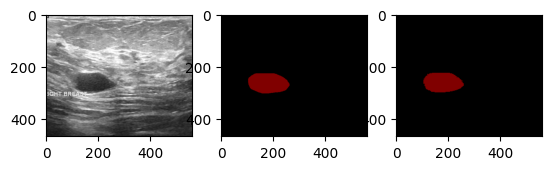

0.9051195888515516
0.9961959407517772
./Dataset_BUSI_with_GT/benign/benign (303).png


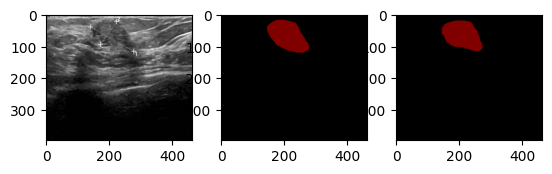

0.8628999594977724
0.9922959624926032
./Dataset_BUSI_with_GT/benign/benign (434).png


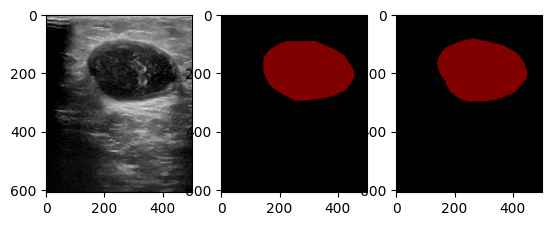

0.9385728581325533
0.9875476423614227
./Dataset_BUSI_with_GT/benign/benign (28).png


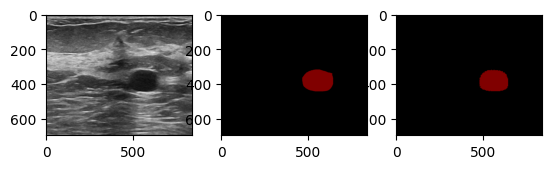

0.905430463576159
0.9968587548350538
./Dataset_BUSI_with_GT/benign/benign (294).png


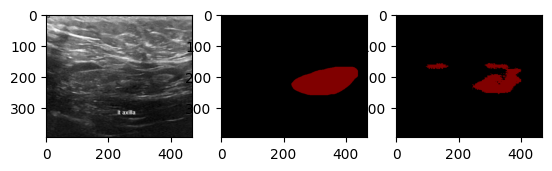

0.47274232581836706
0.9533217187350237
./Dataset_BUSI_with_GT/benign/benign (122).png


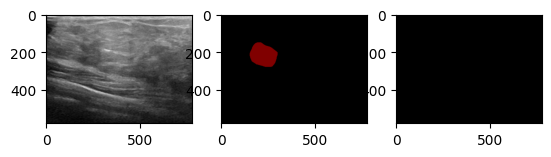

0.0
0.9682510893465712
./Dataset_BUSI_with_GT/benign/benign (129).png


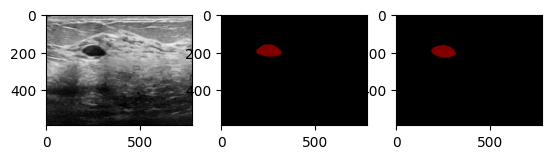

0.8298469745893584
0.9973007523150725
./Dataset_BUSI_with_GT/malignant/malignant (181).png


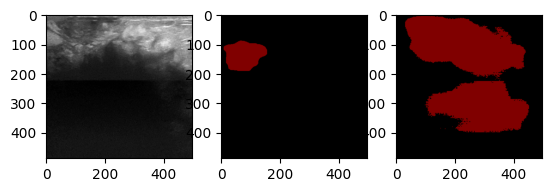

0.050923500442937294
0.5799359163539778
./Dataset_BUSI_with_GT/benign/benign (171).png


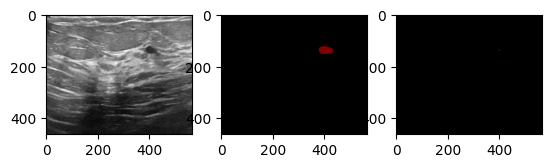

0.018261504747991233
0.9948708750424565
./Dataset_BUSI_with_GT/malignant/malignant (89).png


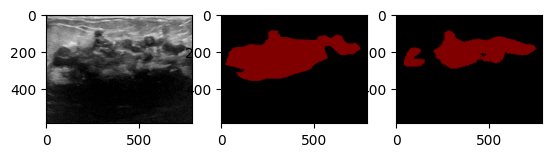

0.5867240420469153
0.8853697269467498
./Dataset_BUSI_with_GT/benign/benign (395).png


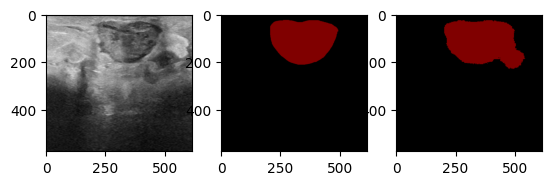

0.8106915154487494
0.9691609542527524
./Dataset_BUSI_with_GT/malignant/malignant (44).png


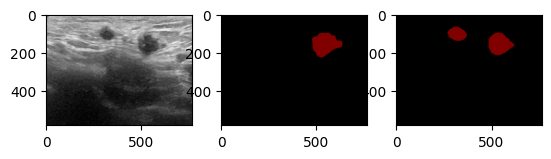

0.5694473409801877
0.9809186234050714
./Dataset_BUSI_with_GT/benign/benign (264).png


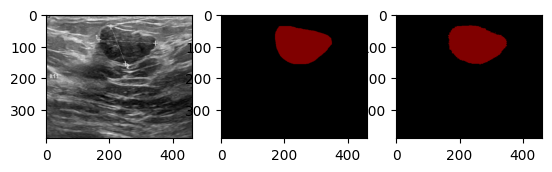

0.9194681530511525
0.9915840442702328
./Dataset_BUSI_with_GT/benign/benign (33).png


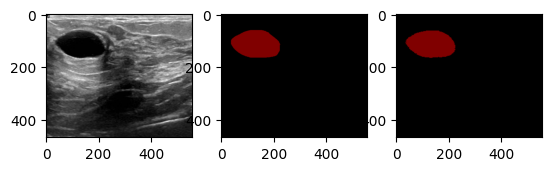

0.9552638287025236
0.9971372411486922
./Dataset_BUSI_with_GT/benign/benign (44).png


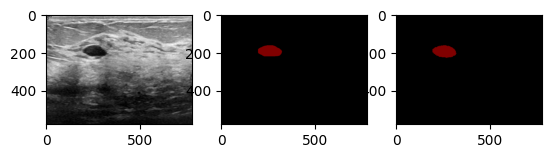

0.8827816580625569
0.9982645679628456
./Dataset_BUSI_with_GT/malignant/malignant (138).png


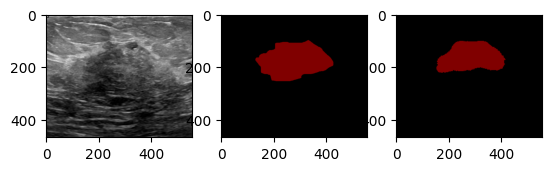

0.722588205485526
0.9630167583612358
./Dataset_BUSI_with_GT/benign/benign (180).png


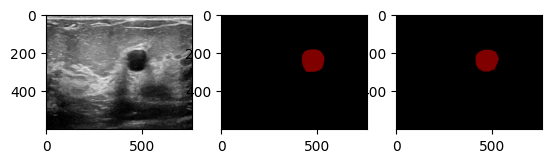

0.8716445031799785
0.9965254098965448
./Dataset_BUSI_with_GT/malignant/malignant (54).png


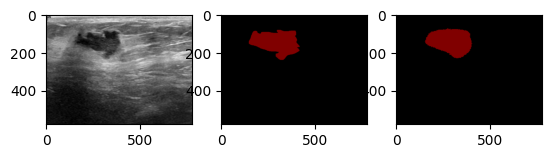

0.8358945298176605
0.9884323658784164
./Dataset_BUSI_with_GT/malignant/malignant (203).png


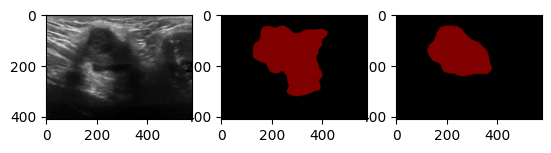

0.6233941228588304
0.8996774415608682
./Dataset_BUSI_with_GT/benign/benign (239).png


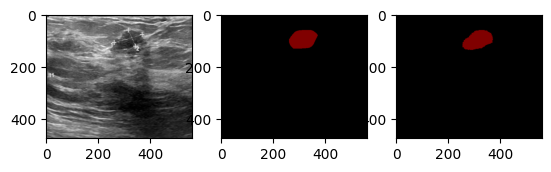

0.815915350050732
0.9951012725119671
./Dataset_BUSI_with_GT/benign/benign (23).png


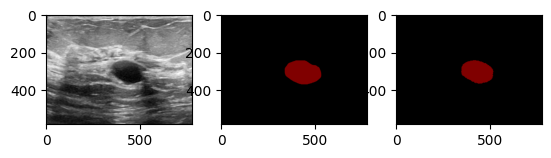

0.8397159389794845
0.9930464588743798
./Dataset_BUSI_with_GT/benign/benign (398).png


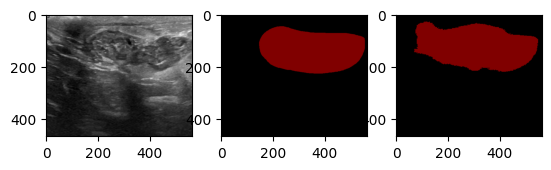

0.7334349894814125
0.910985384252711
./Dataset_BUSI_with_GT/benign/benign (277).png


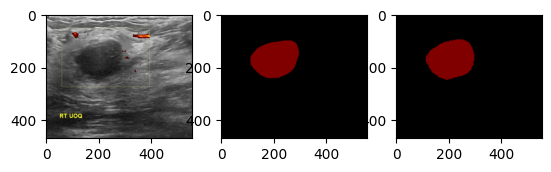

0.9110497237569061
0.9919826040767545
./Dataset_BUSI_with_GT/benign/benign (235).png


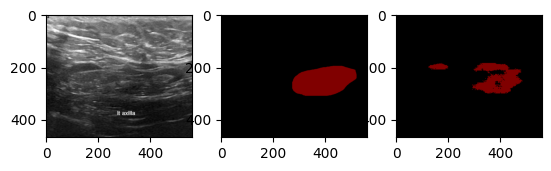

0.4344080923028291
0.9429916442971731
./Dataset_BUSI_with_GT/benign/benign (334).png


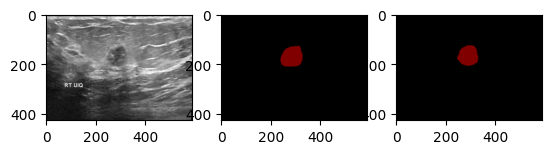

0.8130559085133418
0.995211456701723
./Dataset_BUSI_with_GT/benign/benign (217).png


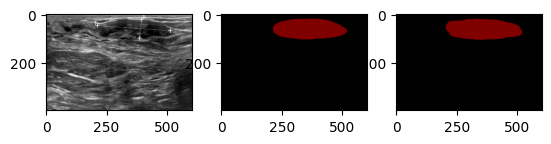

0.9146007979557986
0.9912769133552517
./Dataset_BUSI_with_GT/malignant/malignant (52).png


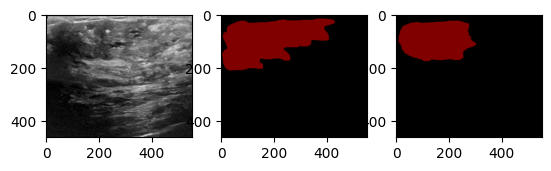

0.6333216051554601
0.910331304568344
./Dataset_BUSI_with_GT/benign/benign (365).png


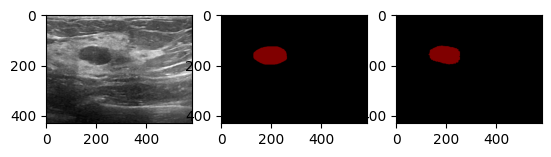

0.8521118088905307
0.9950762948811506
./Dataset_BUSI_with_GT/benign/benign (409).png


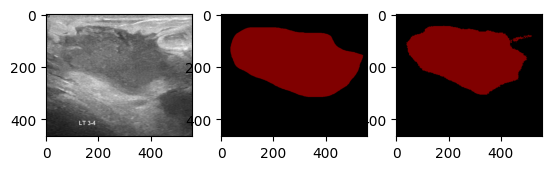

0.8082219875101262
0.896794344714173
./Dataset_BUSI_with_GT/benign/benign (273).png


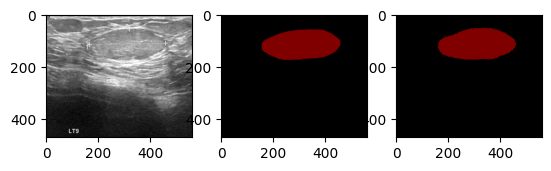

0.9417778244582151
0.9929456180537881
./Dataset_BUSI_with_GT/benign/benign (153).png


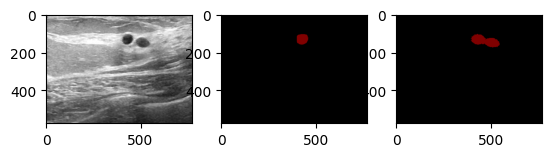

0.4053596180502079
0.9912348806799608
./Dataset_BUSI_with_GT/benign/benign (400).png


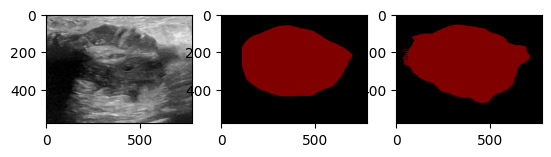

0.8682516671498985
0.9129553457301379
./Dataset_BUSI_with_GT/malignant/malignant (33).png


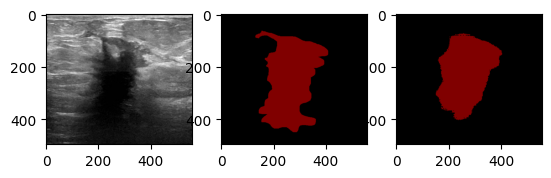

0.7421871393620458
0.9265254036607934
./Dataset_BUSI_with_GT/benign/benign (369).png


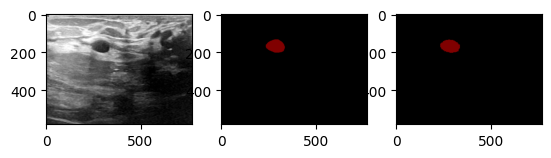

0.8985532508279589
0.9986873473364654
./Dataset_BUSI_with_GT/malignant/malignant (24).png


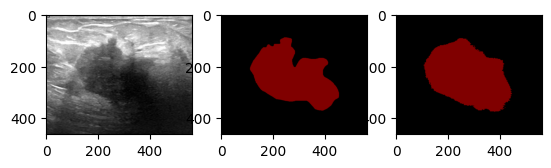

0.8447747803489667
0.9512757641232308
./Dataset_BUSI_with_GT/benign/benign (160).png


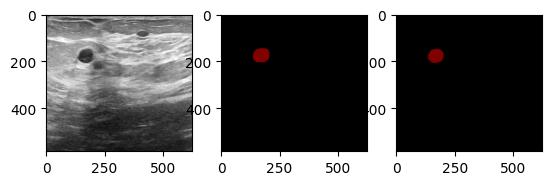

0.8452637244348762
0.9984111589145037
./Dataset_BUSI_with_GT/benign/benign (35).png


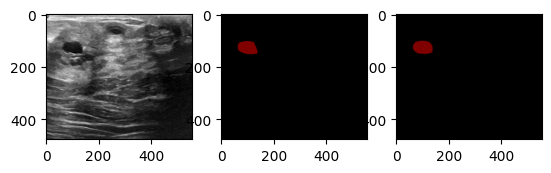

0.8845568077977459
0.9985520645496501
./Dataset_BUSI_with_GT/benign/benign (187).png


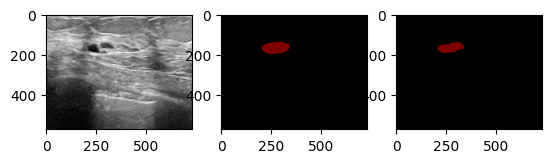

0.7584269662921348
0.9961572368818308
./Dataset_BUSI_with_GT/malignant/malignant (172).png


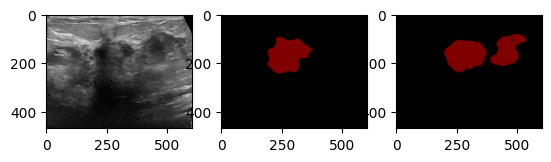

0.48747009192796875
0.9389928575175939
./Dataset_BUSI_with_GT/benign/benign (284).png


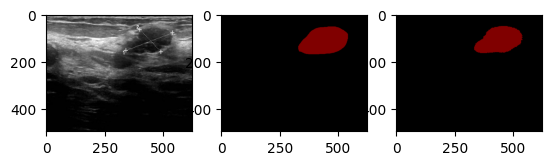

0.8783421079797668
0.9919313151922003
./Dataset_BUSI_with_GT/benign/benign (37).png


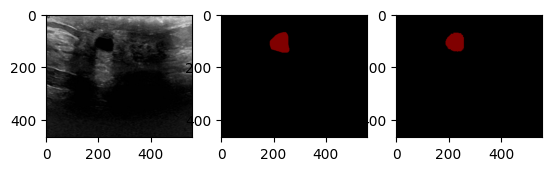

0.8504089539388722
0.9972928230596942
./Dataset_BUSI_with_GT/benign/benign (241).png


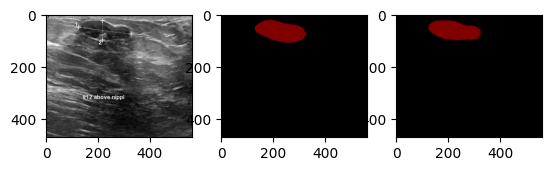

0.8647619047619047
0.9932862107278788
./Dataset_BUSI_with_GT/benign/benign (324).png


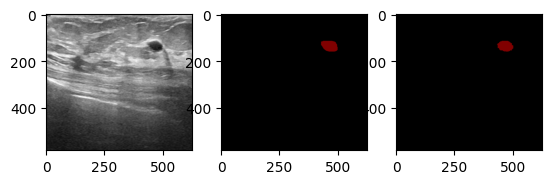

0.8566810344827587
0.9988995319563233
./Dataset_BUSI_with_GT/benign/benign (7).png


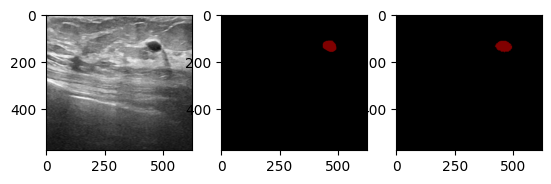

0.7970687711386697
0.998493938100856
./Dataset_BUSI_with_GT/malignant/malignant (36).png


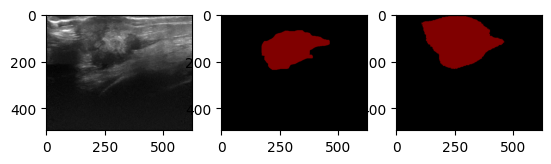

0.5669564207306449
0.9196773880787282
./Dataset_BUSI_with_GT/benign/benign (169).png


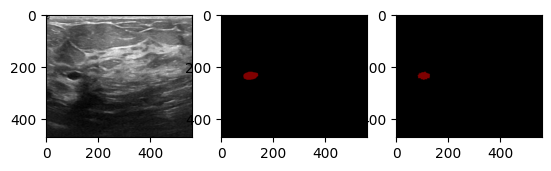

0.700278164116829
0.9983556020175351
./Dataset_BUSI_with_GT/malignant/malignant (64).png


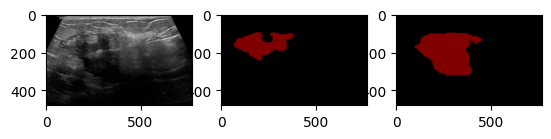

0.4078791523169154
0.9064633682974289
./Dataset_BUSI_with_GT/benign/benign (215).png


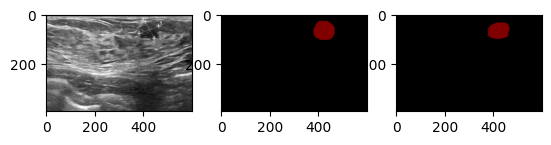

0.8409446084389651
0.9960645651903057
./Dataset_BUSI_with_GT/malignant/malignant (7).png


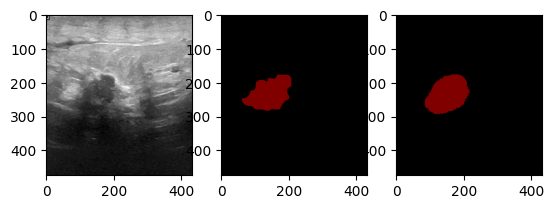

0.7441745574310416
0.9841260920656005
./Dataset_BUSI_with_GT/benign/benign (157).png


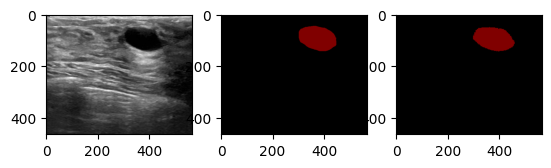

0.8976021844867309
0.9952594652676822
./Dataset_BUSI_with_GT/benign/benign (336).png


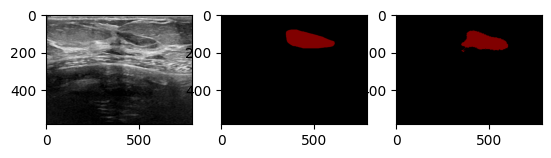

0.7396250680120691
0.9881201168128332
./Dataset_BUSI_with_GT/benign/benign (428).png


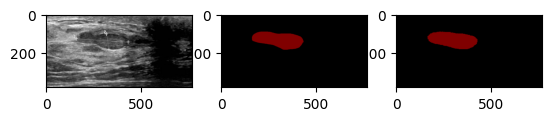

0.8972917454997568
0.9931447291987632
./Dataset_BUSI_with_GT/benign/benign (417).png


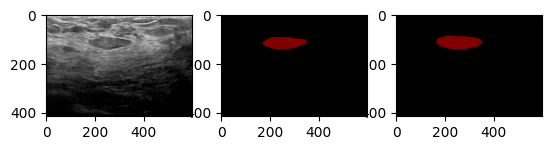

0.8343499581389786
0.9942817743427137
./Dataset_BUSI_with_GT/benign/benign (436).png


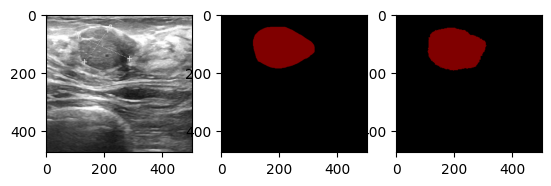

0.8691929537074969
0.985267451356751
./Dataset_BUSI_with_GT/malignant/malignant (93).png


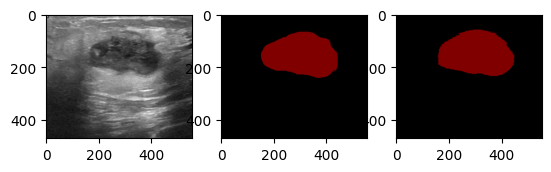

0.906656964343964
0.9834111493130343
./Dataset_BUSI_with_GT/benign/benign (141).png


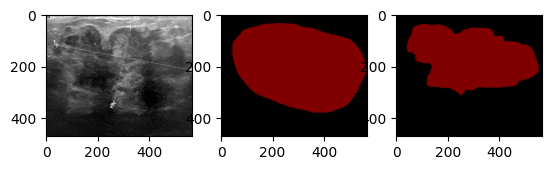

0.6763036627315799
0.7409566241141301
./Dataset_BUSI_with_GT/benign/benign (420).png


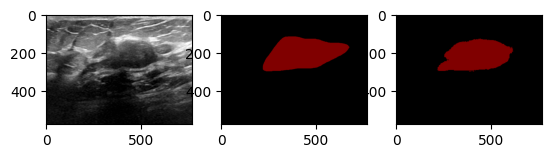

0.7967802308252174
0.9703003396200611
./Dataset_BUSI_with_GT/benign/benign (243).png


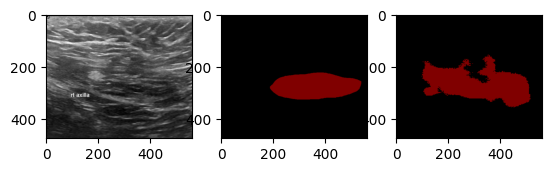

0.5109784605109368
0.9027280162410585
./Dataset_BUSI_with_GT/benign/benign (265).png


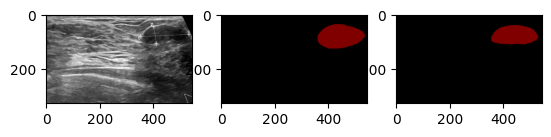

0.8012731575940586
0.985558731777907
./Dataset_BUSI_with_GT/malignant/malignant (55).png


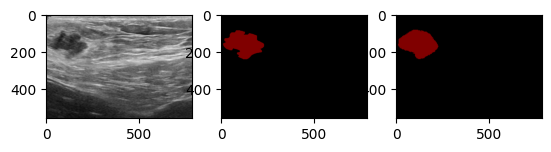

0.8650831560206695
0.992550839858641
./Dataset_BUSI_with_GT/benign/benign (64).png


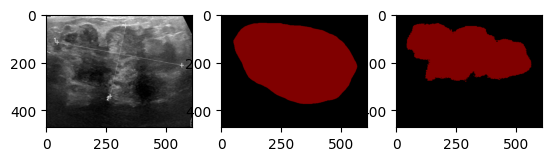

0.6698265260134593
0.7834696750341897
./Dataset_BUSI_with_GT/malignant/malignant (45).png


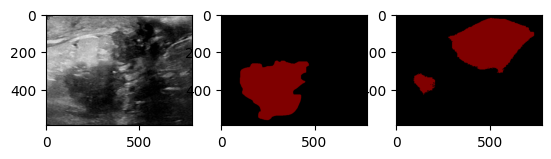

0.0597633797221636
0.6654164568257923
./Dataset_BUSI_with_GT/malignant/malignant (128).png


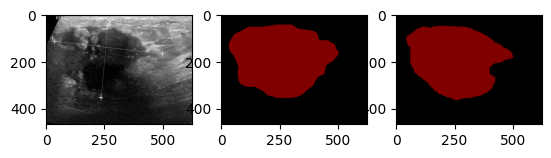

0.8766267712202503
0.9316869544021085
./Dataset_BUSI_with_GT/benign/benign (387).png


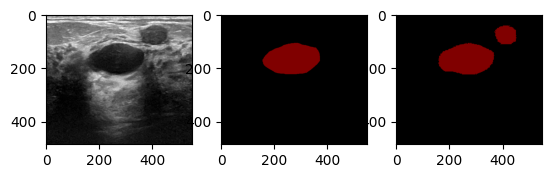

0.7566799785911318
0.9762110813693723
./Dataset_BUSI_with_GT/benign/benign (99).png


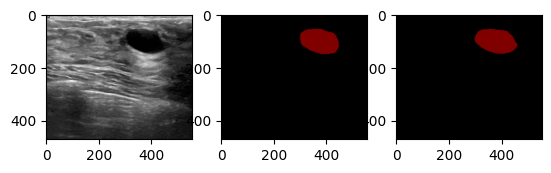

0.9065989847715736
0.9955878473970697
./Dataset_BUSI_with_GT/malignant/malignant (28).png


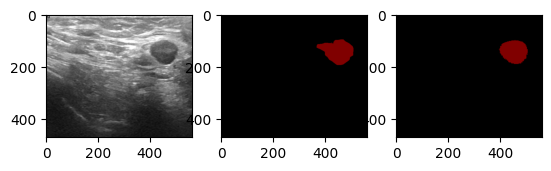

0.8228934462773072
0.993811269020903
./Dataset_BUSI_with_GT/benign/benign (24).png


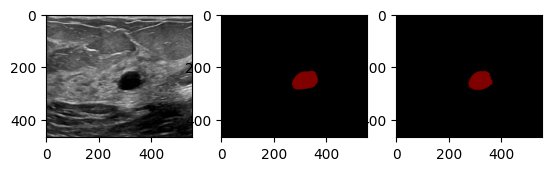

0.8673905304378783
0.997075897150079
./Dataset_BUSI_with_GT/benign/benign (30).png


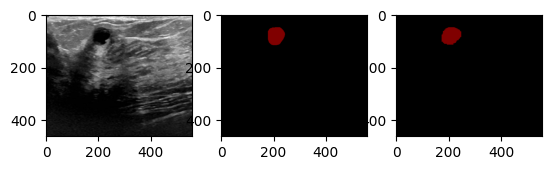

0.8631188118811881
0.9978215224131071
./Dataset_BUSI_with_GT/benign/benign (411).png


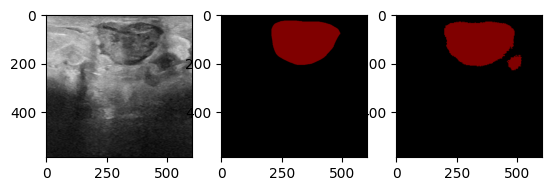

0.8604742308446012
0.9795829284223606
./Dataset_BUSI_with_GT/benign/benign (402).png


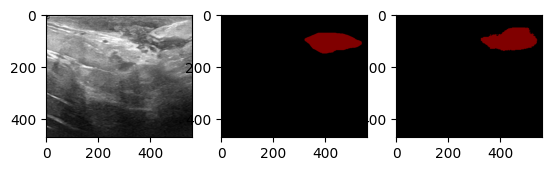

0.6975613006396588
0.9820337238758708
./Dataset_BUSI_with_GT/benign/benign (364).png


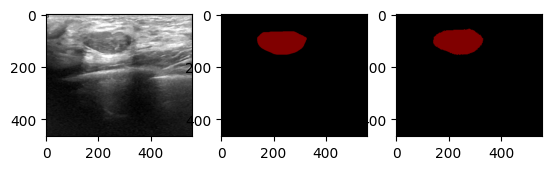

0.8501037691638214
0.9909097183596082
./Dataset_BUSI_with_GT/malignant/malignant (210).png


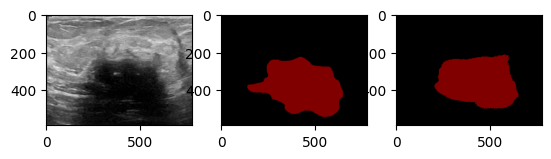

0.766021820020953
0.9300015130718601
./Dataset_BUSI_with_GT/benign/benign (144).png


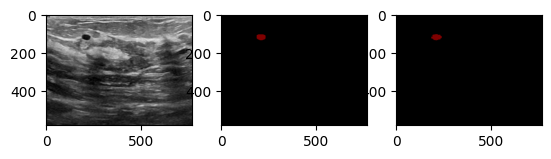

0.8341637010676156
0.9994769076034735
./Dataset_BUSI_with_GT/malignant/malignant (157).png


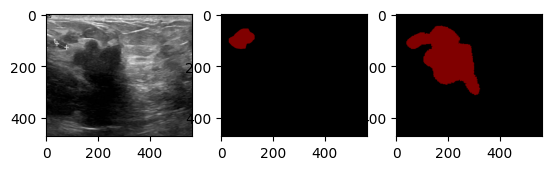

0.09437262357414448
0.863596275212755
./Dataset_BUSI_with_GT/benign/benign (213).png


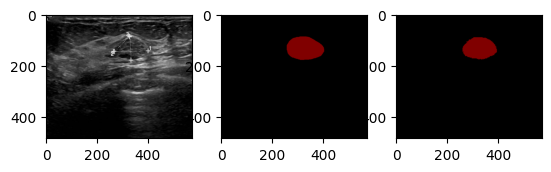

0.8480234537544922
0.9940373491248966
./Dataset_BUSI_with_GT/benign/benign (290).png


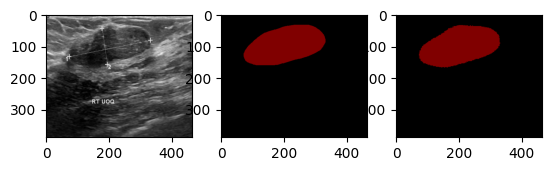

0.9249272009254458
0.9880657966492917
./Dataset_BUSI_with_GT/malignant/malignant (188).png


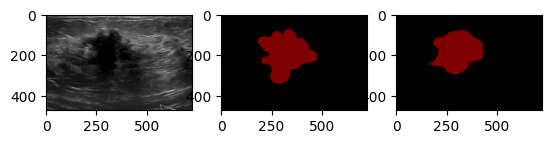

0.7450581817427558
0.9599030443803583
./Dataset_BUSI_with_GT/benign/benign (253).png


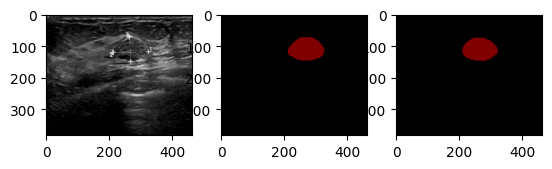

0.8744968372627947
0.9949020707053011
./Dataset_BUSI_with_GT/malignant/malignant (152).png


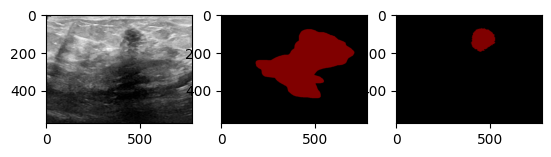

0.11133338145371678
0.8017104321636713
./Dataset_BUSI_with_GT/malignant/malignant (190).png


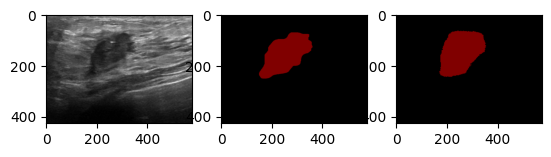

0.8051675162457683
0.9777723519488591
./Dataset_BUSI_with_GT/benign/benign (285).png


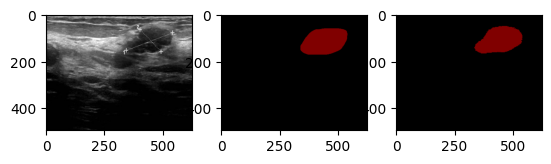

0.8475641697223677
0.9900536623713982
./Dataset_BUSI_with_GT/benign/benign (108).png


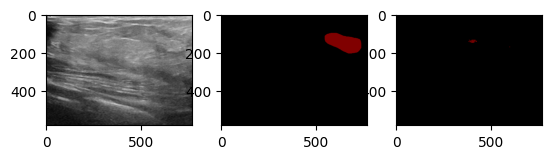

0.00021011346126908532
0.9681044787791445
./Dataset_BUSI_with_GT/benign/benign (173).png


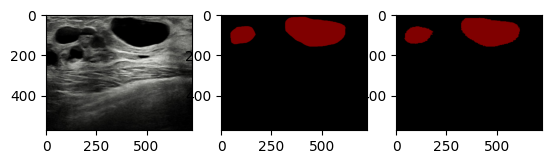

0.9225893333952495
0.9911391765865897
./Dataset_BUSI_with_GT/benign/benign (432).png


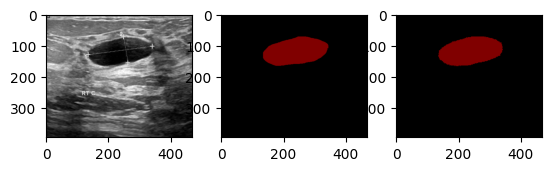

0.9414203557576568
0.9948684303020362
./Dataset_BUSI_with_GT/malignant/malignant (150).png


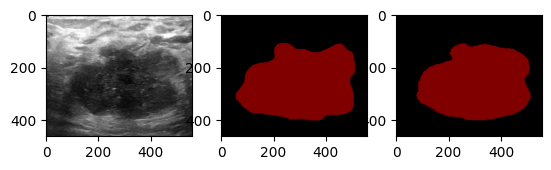

0.8998615247453383
0.935232954022636
./Dataset_BUSI_with_GT/benign/benign (238).png


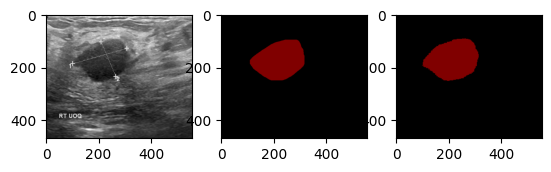

0.8965874248397244
0.9890995937006817
./Dataset_BUSI_with_GT/malignant/malignant (202).png


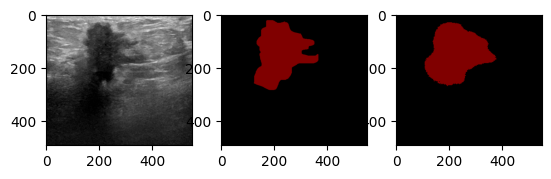

0.8062443696363377
0.965374659487123
./Dataset_BUSI_with_GT/malignant/malignant (46).png


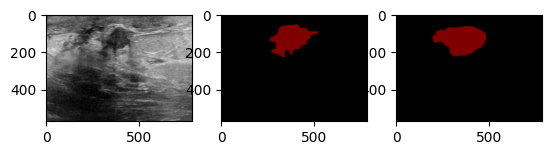

0.6591933501141486
0.972648239541663
./Dataset_BUSI_with_GT/benign/benign (67).png


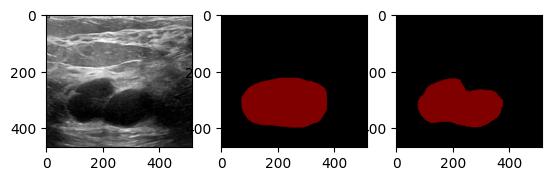

0.8284234234234235
0.9626916107546892
./Dataset_BUSI_with_GT/benign/benign (156).png


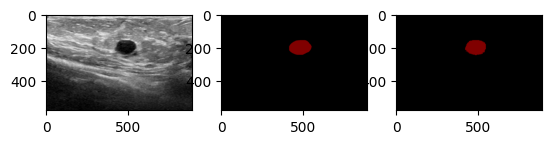

0.8895860742839794
0.9978462443515734
./Dataset_BUSI_with_GT/malignant/malignant (148).png


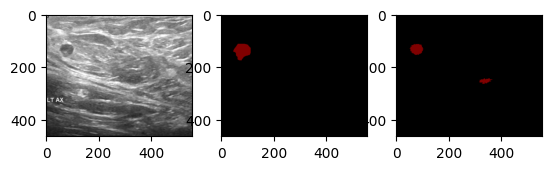

0.4522366522366522
0.9925819097087872
./Dataset_BUSI_with_GT/benign/benign (220).png


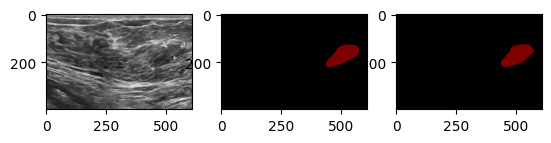

0.8730837789661319
0.9954323252800267
./Dataset_BUSI_with_GT/malignant/malignant (165).png


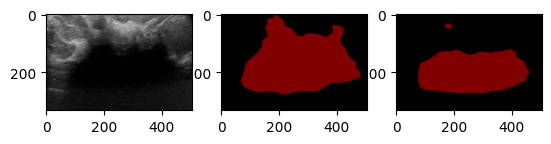

0.6352555411051772
0.7834572261694526
./Dataset_BUSI_with_GT/benign/benign (76).png


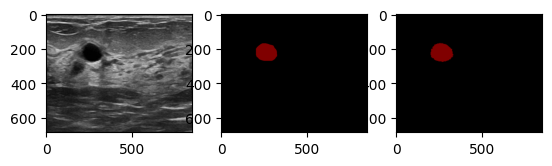

0.9151208035471903
0.9983565973505827
./Dataset_BUSI_with_GT/malignant/malignant (131).png


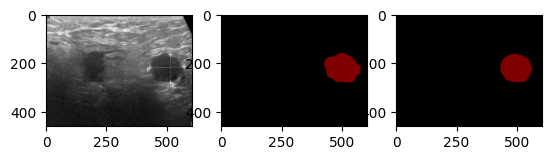

0.8548816461615943
0.9924332800624245
average tumor IoU: 0.7432950491954977
average background IoU: 0.9617645106280045


In [8]:
# Step 4: IoU and segmentation results
model = torch.load("./save_models/Vmamba_Multi.pt")
model = model.to(device)
from utility import VOCPalette

total_tumor_IoU = []
total_background_IoU = []
palette = VOCPalette(nb_class=2)

for test_image in images_test:
    image = Image.open(test_image)
    print(test_image)
    label = Image.open(test_image[:-4] + "_mask.png")
    
    image_resize = image.convert("RGB").resize((224, 224))
    image_resize = np.array(image_resize)
    img_new = np.float32(image_resize)
    img_new = img_new /127.5 -1

  
    tfms = transforms.Compose([
            transforms.ToTensor()
        ])

    image_tensor = tfms(img_new).unsqueeze(0).to(device)

    predict = model(image_tensor)[1].squeeze(0)

    predict_label = torch.argmax(predict, 0)

    predict_label = predict_label.cpu().numpy().astype('uint8')

    # resize the predict result to original size
    
    PIL_predicr_pal_U = palette.genlabelpal(predict_label)
    PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(PIL_img_pal)
    plt.show()

    # Compute IoU between thresh1 and label

    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    # IoU

    print(compute_iou(np.array(PIL_img_pal), np.array(label)))
    print(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
    total_tumor_IoU.append(compute_iou(np.array(PIL_img_pal), np.array(label)))
    total_background_IoU.append(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
print("average tumor IoU:", np.mean(total_tumor_IoU))
print("average background IoU:", np.mean(total_background_IoU))

In [7]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix
model = torch.load("./save_models/Vmamba_Multi.pt")
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    model = model.to(device)
    
    true_labels = []
    probabilities = []
    predictions = []  # Correctly initialize the predictions list

    with torch.no_grad():  # Do not compute gradients
        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs, _ = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
            preds = (probs >= threshold).cpu().numpy().astype(int)  # Binary predictions based on the threshold
            
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            predictions.extend(preds)  # Add the predictions to the list

    # Convert lists to numpy arrays for consistency
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)
    predictions = np.array(predictions)
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    auc = roc_auc_score(true_labels, probabilities)  # AUC using probabilities

    # Compute confusion matrix and extract TN, FP, FN, TP for calculating TPR and FPR
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    
    return accuracy, precision, f1, auc, tpr, fpr

# Assuming 'device' and 'test_loader' are already defined
# Evaluate the model and print the metrics
accuracy, precision, f1, auc, tpr, fpr = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nF1 Score: {f1}\nAUC: {auc}\nTPR: {tpr}\nFPR: {fpr}")


Accuracy: 0.9
Precision: 0.8095238095238095
F1 Score: 0.8395061728395062
AUC: 0.9456184840800226
TPR: 0.8717948717948718
FPR: 0.08791208791208792
